<a href="https://colab.research.google.com/github/subhobrata/DeepNLP/blob/master/Chapter_3_Diving_Deep_into_Supervised_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [0]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

In [0]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """

    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.fc1(x_in))

In [0]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

In [0]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

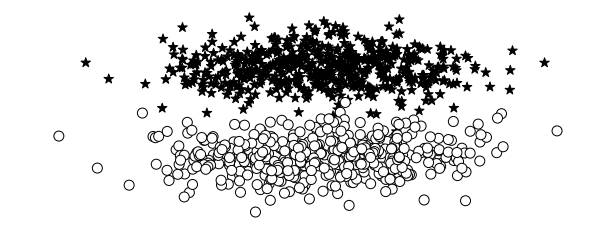

In [6]:
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

left_x = []
right_x = []
left_colors = []
right_colors =  []

for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, ax = plt.subplots(1, 1, figsize=(10,4))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)

plt.axis('off');

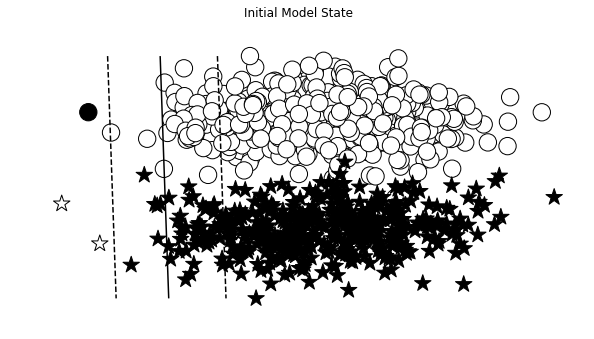

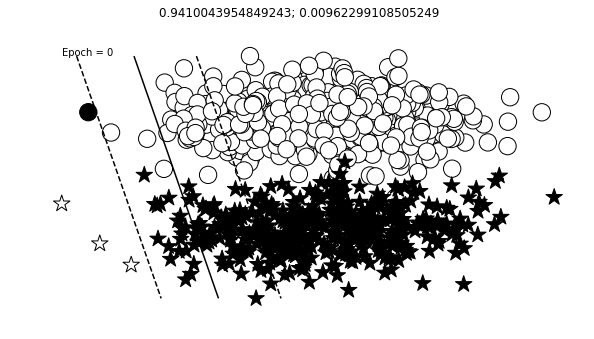

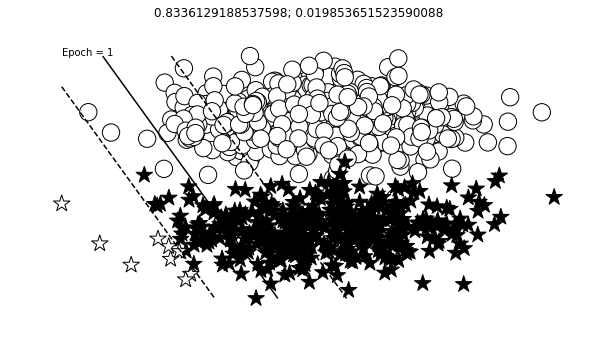

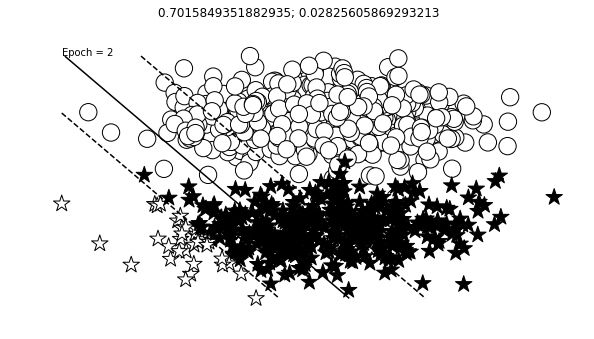

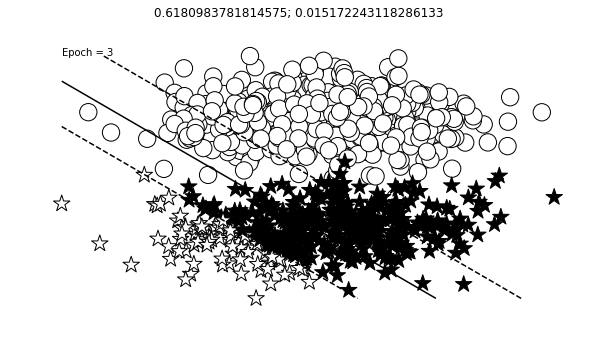

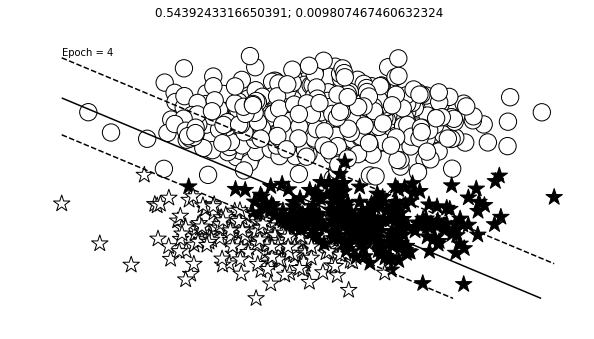

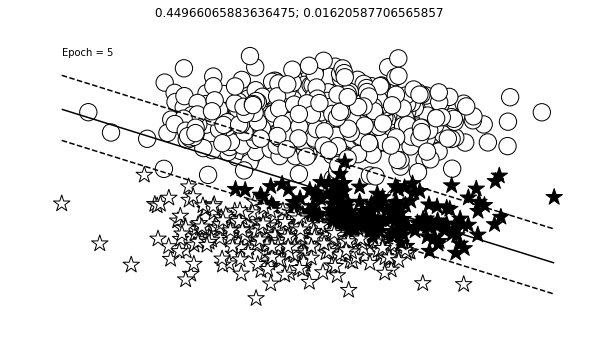

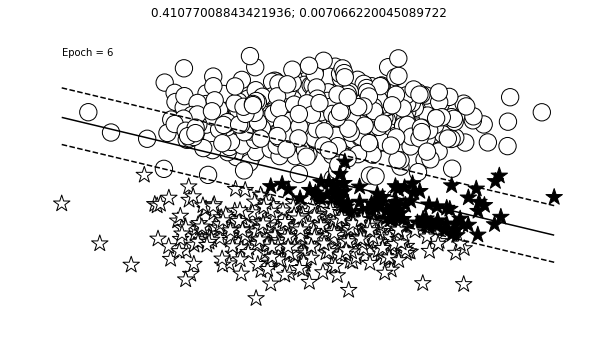

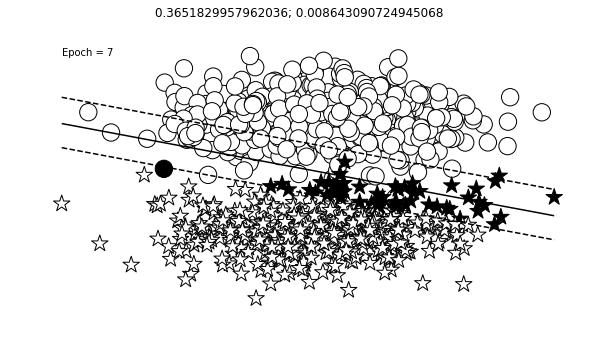

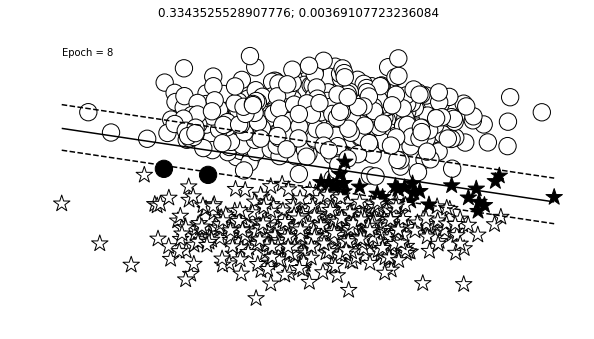

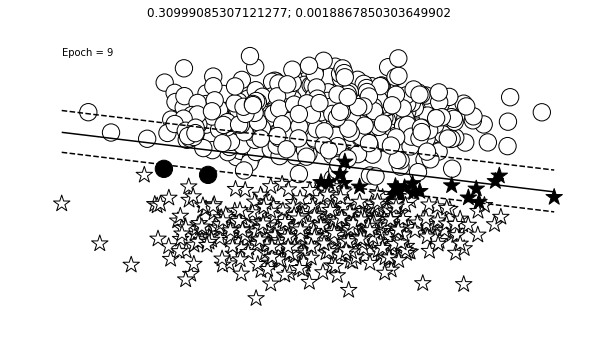

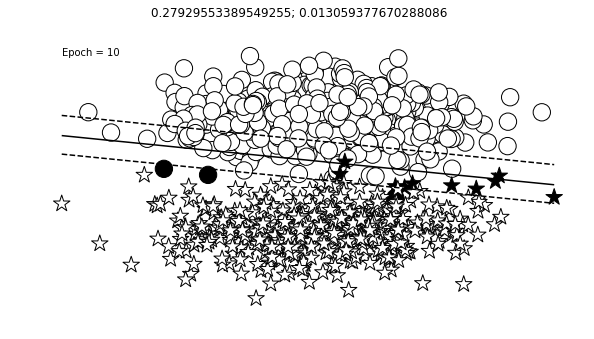

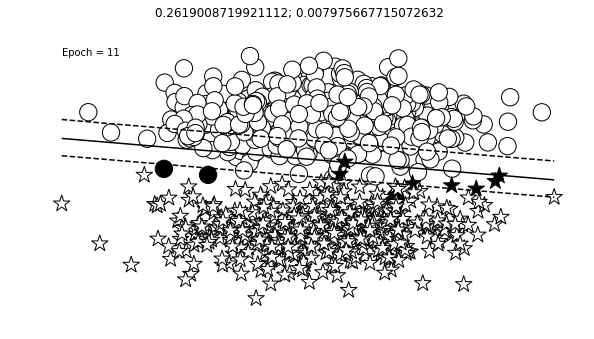

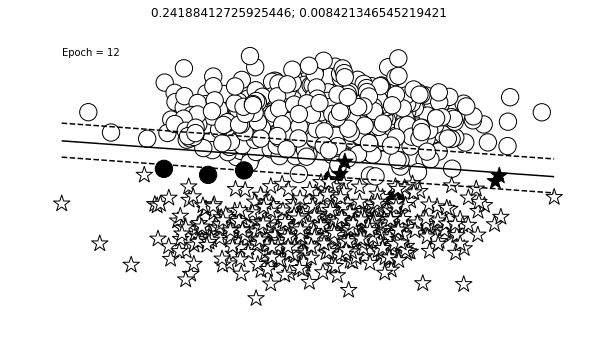

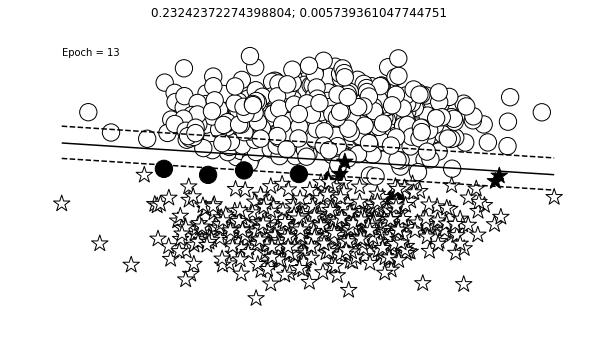

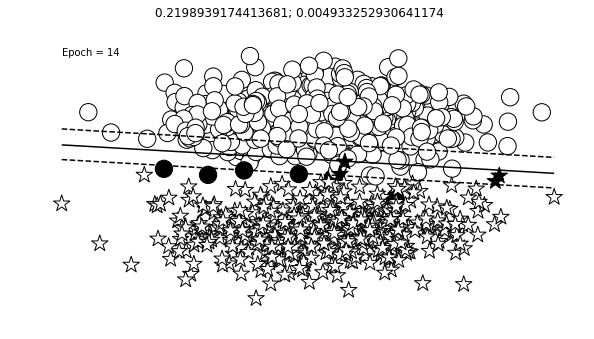

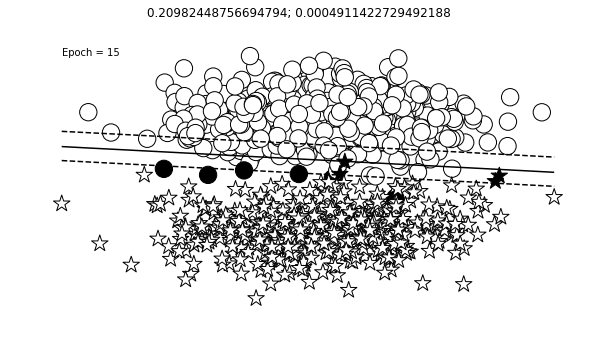

In [7]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

perceptron = Perceptron(input_dim=input_dim)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
#plt.savefig('initial.png')

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
while change > epsilon or epoch < n_epochs or last > 0.3:
#for epoch in range(n_epochs):
    for _ in range(n_batches):

        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        
        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
               
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1
    #plt.savefig('epoch{}_toylearning.png'.format(epoch))

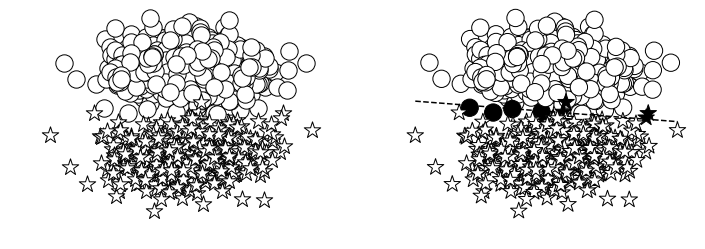

In [8]:
_, axes = plt.subplots(1,2,figsize=(12,4))


axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');
plt.savefig('perceptron_final.png')
plt.savefig('perceptron_final.pdf')